In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import functools
import jax
import jax.numpy as jnp
import jax_flock as jf
import numpy as np
import matplotlib.pyplot as plt
import stats

params = jf.Params(
    weight_forward  = 0.20,
    weight_separate = 1.00,
    weight_align    = 0.30,
    weight_cohere   = 0.60,
    weight_avoid    = 2.00
)

config = jf.Config(
    boid_count = 25,
    sphere_radius = 30.0
)

def next_state(state):
    return jf.next_state(params, config, 1/60, state)

initial_state = stats.advance(jf.init_state(config, jax.random.PRNGKey(0)), next_state, 100_000)

DF = jax.jacfwd(next_state)
print(DF(initial_state).position.position.shape)

(25, 3, 25, 3)


In [46]:
def F(state, n_steps):
    return jax.lax.fori_loop(0, n_steps, lambda _, state: next_state(state), state)
def dF(n_steps):
    return jax.jacfwd(lambda state: F(state, n_steps))

nearest_neighbors = jax.vmap(lambda pos: jf.nearest_neighbors(pos, initial_state.position))(initial_state.position)
dF_1 = dF(1)
pos_pos = dF_1(initial_state).position.position
# As expected, nearest neighbors match nonzero entries of jacobian
# print(nearest_neighbors)
print(jnp.sort(nearest_neighbors[0]))
print(jnp.arange(config.boid_count)[jnp.any(jnp.abs(pos_pos[0][0]) > 1e-09, axis=1)])
print(jnp.sort(nearest_neighbors[11]))
print(jnp.arange(config.boid_count)[jnp.any(jnp.abs(pos_pos[11][0]) > 1e-09, axis=1)])

# How does influence change over time in the subflock?

dF_10 = dF(10)
pos_pos_10 = dF_10(initial_state).position.position
# Biggest influence is still from nearest neighbors
print(jnp.argsort(jnp.max(jnp.abs(pos_pos_10[0][0]), axis=1)))

dF_20 = dF(20)
pos_pos_20 = dF_20(initial_state).position.position
# Biggest influence is still from nearest neighbors
print(jnp.argsort(jnp.max(jnp.abs(pos_pos_20[0][0]), axis=1)))


[ 7  9 12 14 17 18 22]
[ 0  7  9 12 14 17 18 22]
[ 5  6  9 17 21 22 23]
[ 5  6  9 11 17 21 22 23]
[19 20  4  5  2 15 24 11 16 13  3 23 21  1 10  8 14  6 22 12  9 18 17  7
  0]
[19 20  2  4  5 11 24 15  3 23 16 13 21  1 10  8 22 14  6 12 17 18  9  7
  0]


In [48]:

vals, vecs = np.linalg.eig(dF(50)(initial_state).position.position.reshape(-1, config.boid_count * 3))
print(jnp.real(vals))
print(jnp.real(vals[0]))
print(jnp.real(vecs[0]))
print(jnp.arange(config.boid_count * 3)[jnp.abs(vecs[0]) > 1e-01])

# dG_dstate = jax.jacfwd(G, argnums=0)
# pos_pos = dG_dstate(initial_state).position.position.reshape(-1, config.boid_count * 3)
# L = jnp.linalg.eigvals(pos_pos)
# with jnp.printoptions(threshold=jnp.inf):
    # print(pos_pos)
# print(jnp.real(L))

# dGn_dstate = jax.jacfwd(lambda state: Fn(state, 100), argnums=0)
# pos_pos = dGn_dstate(initial_state).position.position.reshape(-1, config.boid_count * 3)
# L = jnp.linalg.eigvals(pos_pos)
# print(jnp.real(L))
# print(jnp.real(L) < 0)


[-1.034746   -1.034746    4.6153064   2.8314562   2.8314562  -3.2631688
 -2.928938   -2.928938   -2.7996929  -2.7996929  -1.9249679   3.0369022
 -1.1725047  -1.1725047   2.5600085   2.5600085  -1.0801324  -1.0801324
 -0.6975396  -0.6975396   2.3113413   2.3113413   1.5728301   1.5728301
 -0.5941236  -0.5941236  -0.52102035 -0.52102035 -0.518994    0.4267869
  0.4267869  -0.34266725 -0.34266725 -0.28333142 -0.10492276 -0.10492276
  1.2538693   1.2538693  -0.07317506  1.572743    1.572743    1.5437285
  1.5437285   1.4946935   0.9809667   0.9809667   0.3353899   0.3353899
  0.31810498  0.31810498  0.9888603   0.9888603   0.6698327   0.6698327
  0.6955864   0.6955864   0.49325198  0.49325198  0.47625875  0.47625875
  1.3291532   1.3291532   0.9534004   0.9534004   1.1846691   1.1846691
  0.8254448   0.8254448   1.0910571   1.0910571   0.93422693  0.9735805
  0.99837905  0.99837905  0.99819785]
-1.034746
[ 0.2486579   0.2486579   0.00631399  0.33687502  0.33687502 -0.0185559
 -0.00178764 -

initial l2 = 8.642309188842773
initial grad norm = 1.037650227546692
[8.64010906e+00 8.63997269e+00 8.63956451e+00 8.64070988e+00
 8.64099121e+00 8.64059925e+00 8.64087677e+00 8.64060211e+00
 8.64005661e+00 8.63869095e+00 8.63817596e+00 8.63796902e+00
 8.63803768e+00 8.63756561e+00 8.63346672e+00 8.63295078e+00
 8.63106441e+00 8.63203812e+00 8.63394451e+00 8.63203716e+00
 8.63168430e+00 8.62920094e+00 8.62714005e+00 8.62636185e+00
 8.62603664e+00 8.62494850e+00 8.62456417e+00 8.62415886e+00
 8.62241650e+00 8.62277603e+00 8.62358856e+00 8.62476444e+00
 8.62432957e+00 8.62627602e+00 8.62265205e+00 8.62298679e+00
 8.62383842e+00 8.62409782e+00 8.62239647e+00 8.62214088e+00
 8.61849880e+00 8.61479950e+00 8.61219978e+00 8.60886669e+00
 8.60542965e+00 8.59986210e+00 8.59642792e+00 8.59691143e+00
 8.59613514e+00 8.59212971e+00 8.58650398e+00 8.58465481e+00
 8.58301449e+00 8.57966042e+00 8.58086014e+00 8.57878208e+00
 8.57419300e+00 8.57426739e+00 8.57672119e+00 8.57824421e+00
 8.57834435e+00 

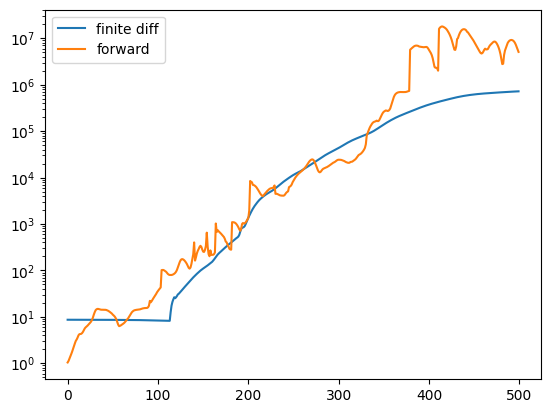

In [84]:
finite_diff = 1e-04
state_0 = initial_state
state_1 = initial_state.replace(position=initial_state.position + finite_diff)

def l2(state_0, state_1):
    return jnp.sqrt(jnp.sum(jnp.square(state_0.position - state_1.position)) + jnp.sum(jnp.square(state_0.forward - state_1.forward)) + jnp.sum(jnp.square(state_0.speed - state_1.speed))) / finite_diff

def grad_norm(state, n_steps):
    J = dF(n_steps)(state)
    return jnp.sqrt(jnp.sum(J.position.position[:,:,0,0] ** 2) + jnp.sum(J.position.forward[:,:,0,0] ** 2) + jnp.sum(J.position.speed[:,0,0] ** 2))

print(f"initial l2 = {l2(state_0, state_1)}")
print(f"initial grad norm = {grad_norm(state_0, 1)}")

@functools.partial(jax.jit, static_argnames=['n_steps'])
def trajectory(states, n_steps):
    def step(states, _):
        state_0, state_1 = states
        state_0, state_1 = next_state(state_0), next_state(state_1)
        return (state_0, state_1), l2(state_0, state_1)
    return jax.lax.scan(step, states, None, length=n_steps)[1]

@functools.partial(jax.jit, static_argnames=['n_steps'])
def grad_trajectory(state, n_steps):
    def step(state_0, i):
        state_0 = next_state(state_0)
        return state_0, grad_norm(state_0, i)
    return jax.lax.scan(step, state, jnp.arange(1, n_steps + 1))[1]

l2s = trajectory((state_0, state_1), 500)
grads = grad_trajectory(state_0, 500)
print(l2s)
plt.yscale('log')
plt.plot(l2s, label='finite diff')
plt.plot(grads, label='forward')
plt.legend()